## Problem Statement

In the words of the Prime Minister of Singapore on 7 June 2020 in a national broadcast, "COVID-19 is not only a public health issue. It is also a serious economic, social and political problem. It is in fact the most dangerous crisis humanity has faced in a very long time."("PM Lee Hsien Loong: Overcoming the crisis of a generation",2020).

The impact of COVID-19 is evident on businesses and economies across the globe. In April, bookstore sales plummeted to $219 million, a decline of more than 65\% from April 2019, according to figures released Tuesday by the US Commerce Department("Bookstores are struggling. Is a new e-commerce site the answer?",2020). Even before the pandemic, independent players in the book industry had to contend with bigger players like Amazon and rising rents("What Could Kill My New York Bookstores?",2020). 

Beyond the pandemic, independent bookstores that have changed course and joined the online retail ecosystem can explore implementing recommendation systems that if set up and configured properly, can significantly boost revenues and have positive effects on the user experience as well, which translates into metrics that are harder to measure but are nonetheless of much importance to online businesses, such as customer satisfaction and retention.

This project seeks to identify the best recommendation model that obtains the best top-N accuracy metrics for the dataset. The techniques that will be explored in this project include: content-based, collaborative-filtering and hybrid. Content-based models users’ tastes based upon their past behaviors, but does not benefit from data on other users. On the contrary, collaborative filtering use the collaborative power of the ratings provided by multiple users to make recommendations and rely mostly on leveraging either inter-item correlations or inter-user interactions for the prediction process. Intuitively, it relies on an underlying notion that two users who rate items similarly are likely to have comparable preferences for other items. The hybrid technique seeks to combine various aspects from different types of systems to achieve the best of all worlds. The approach is comparable to the conventional ensemble analysis approach, where the power of multiple types of machine learning algorithms is combined to create a more robust model.



In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load
import matplotlib.pyplot as plt
import math
import os.path
import seaborn as sns
import sklearn
import requests
import re
import scipy
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords
import gensim
import spacy
import pickle
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import defaultdict 
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from pprint import pprint
import urllib.request
import datetime
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix, coo_matrix, dok_matrix, vstack, hstack
from plotly.offline import init_notebook_mode, plot, iplot
from math import sqrt 
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error,mean_squared_error
import plotly.graph_objs as go
init_notebook_mode(connected=True)
sns.set()

In [2]:
%%capture
from tqdm import tnrange,tqdm_notebook as tqdm
tqdm().pandas()

## Executive Summary


### Contents:
- [Reviews](#Reviews)
- [Books metadata](#Books-metadata)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Evaluation](#Evaluation)
- [Model fit and evaluation](#Model-fit-and-evaluation)
    - [Popularity Model](#Popularity-Model)
    - [Content-Based Filtering Model](#Content-Based-Filtering-Model)
    - [Collaborative filtering](#Collaborative-filtering)
    - [Hybrid Modelling](#Hybrid-Modelling)
    - [Comparison of methods](#Comparison-of-methods)
    - [Recommendations for user](#Recommendations-for-user)
- [Business Recommendations](#Business-Recommendations)

The retrieval of the reviews and books metadata datasets are documented separately in the Data.ipynb notebook.

## Reviews

The dataset in the amazon_book_reviews.csv is a subset(1212723 reviews) of the original dataset( Ni *et al* , 2019) comprising of 27,164,983 reviews from the book category itself. The reviews span from 1996 to 2018.

In [68]:
combined = pd.read_csv('/Users/jocelynpok/Downloads/amazon_book_reviews.csv')

In [4]:
combined.shape

(1212723, 12)

In [5]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212723 entries, 0 to 1212722
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         1212723 non-null  int64 
 1   verified        1212723 non-null  bool  
 2   reviewTime      1212723 non-null  object
 3   reviewerID      1212723 non-null  object
 4   asin            1212723 non-null  object
 5   style           1202103 non-null  object
 6   reviewerName    1212650 non-null  object
 7   reviewText      1212594 non-null  object
 8   summary         1212569 non-null  object
 9   unixReviewTime  1212723 non-null  int64 
 10  image           1530 non-null     object
 11  vote            278428 non-null   object
dtypes: bool(1), int64(2), object(9)
memory usage: 102.9+ MB


Four features are heuristically chosen that are not sparse, which are the overall rating assigned, review text, asin of the book, and the datetime at which the review was written.

In [69]:
combined.drop(['style','summary','image','vote','reviewerName','reviewTime','verified'],axis=1,inplace=True)

In [70]:
combined.dropna(subset=['reviewText'],inplace=True)

In [8]:
combined.isnull().sum()

overall           0
reviewerID        0
asin              0
reviewText        0
unixReviewTime    0
dtype: int64

In [71]:
combined['review_Datetime'] = pd.to_datetime(combined['unixReviewTime'], unit='s')

In the review dataset, there were cases where a unique user would rate one book several times throughout his/her history. In this instance, only the most recent review is kept since it reflects the user’s latest preference.

In [72]:
combined_latest = combined.loc[combined.groupby(['reviewerID', 'asin']).review_Datetime.idxmax(),['reviewerID', 'asin','overall','review_Datetime','reviewText']]

In [11]:
combined_latest.shape

(1204430, 5)

In [12]:
combined_latest['review_Datetime'].max()

Timestamp('2018-05-02 00:00:00')

In [13]:
combined_latest['review_Datetime'].min()

Timestamp('1996-09-18 00:00:00')

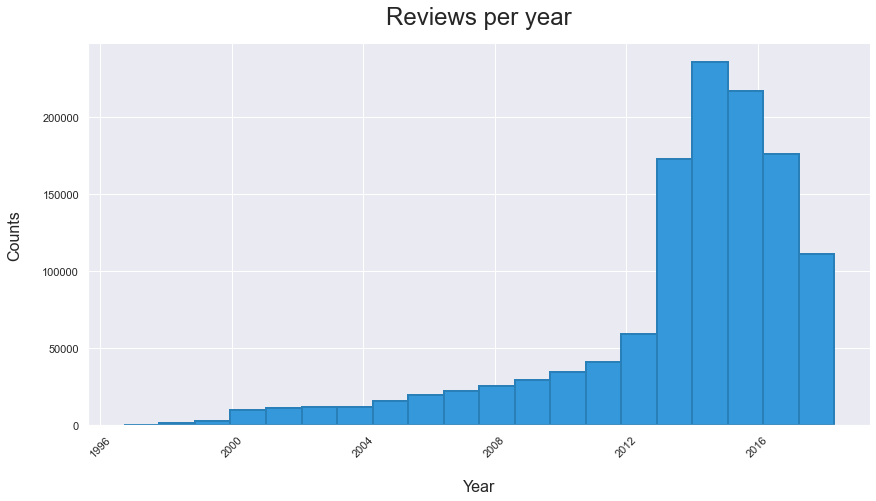

In [14]:
def make_histogram(dataset, attribute, bins=20, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    #if attribute == 'moviePubYear':
    #    dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(combined_latest, 'review_Datetime', title='Reviews per year', xlab='Year', ylab='Counts')

59% of all ratings in the data are 5, and very few ratings are 1 or 2, or 3. 

In [15]:
data = combined_latest['overall'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / combined_latest.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(combined_latest.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Books metadata

The associated meta-data for the books that have reviews are retrieved and saved in the amazon_book_meta.csv

In [52]:
data_with_meta = pd.read_csv('/Users/jocelynpok/Downloads/books_meta/amazon_book_meta.csv')

In [17]:
data_with_meta.shape

(17932, 12)

In [18]:
data_with_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17932 entries, 0 to 17931
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  17502 non-null  object
 1   title        17932 non-null  object
 2   also_buy     16292 non-null  object
 3   brand        17916 non-null  object
 4   rank         17932 non-null  object
 5   also_view    16172 non-null  object
 6   main_cat     17932 non-null  object
 7   price        13896 non-null  object
 8   asin         17932 non-null  object
 9   category     17804 non-null  object
 10  image        1 non-null      object
 11  feature      1 non-null      object
dtypes: object(12)
memory usage: 1.6+ MB


In [53]:
# Retrieve books with no descriptions
data_with_meta_no_desc = data_with_meta.loc[(data_with_meta['description'].isnull()),:]

In [54]:
# Get asin of the books with no descriptions
asin_no_desc_list = data_with_meta_no_desc['asin'].tolist()

In [55]:
data_with_meta.dropna(subset=['description'],inplace=True)
data_with_meta.reset_index(inplace=True,drop=True)

Four features are heuristically chosen that are not sparse, which are the description, title, asin of the book, and the categories assigned to the book.

In [56]:
data_with_meta.drop(['also_buy','brand','rank','also_view','main_cat','price','image','feature'],axis=1,inplace=True)

In [23]:
data_with_meta.shape

(17502, 4)

In [43]:
data_with_meta.isnull().sum()

description     0
title           0
asin            0
category       98
dtype: int64

In [57]:
data_with_meta['category'].fillna('uncategorised',inplace=True)

In [58]:
data_with_meta['category'] = data_with_meta['category'].str.strip('[]')

In [46]:
data_with_meta.isnull().sum()

description    0
title          0
asin           0
category       0
dtype: int64

In [28]:
data_with_meta.head()

,description,title,asin,category
0,"['', 'MARILYNNE ROBINSON is the recipient of a...",Gilead,0002005883,"'Books', 'Literature & Fiction', 'Contemporary'"
1,"['', ""'His best since H.M.S. Ulysses' Sunday T...",Goodbye California,0006153607,"'Books', 'Literature & Fiction', 'Action & Adv..."
2,['Title: The File( A Personal History) <>Bindi...,The File: A Personal History,0006388477,"'Books', 'Politics & Social Sciences', 'Politi..."
3,['Book eleven of the celebrated Deverry series...,The Fire Dragon (Dragon Mage),0006482619,"'Books', 'Science Fiction & Fantasy', 'Fantasy'"
4,"[""`There's no resisting the appeal of King's t...",The Moor,0006510868,"'Books', 'Mystery, Thriller & Suspense', 'Myst..."


The category column is a list of strings, comprising of tags that is associated with each book. In order to proceed with book category or essentially genre exploration, the column values will be split on the comma(,) character and a corresponding new entry will be created for each genre.

Not taking into consideration the generic 'Books' tag, some insights that can be derived from the bar chart plot are that most books reside in the fiction, children literature or mystery category.

In [29]:
genre_df = pd.DataFrame(data_with_meta['category'].str.split(',').tolist(), index=data_with_meta['asin']).stack()
genre_df = genre_df.reset_index([0, 'asin'])
genre_df.columns = ['asin', 'Genre']
genre_df['Genre'] = genre_df['Genre'].str.replace("'", '')
genre_df['Genre'] = genre_df['Genre'].str.replace('"', '')

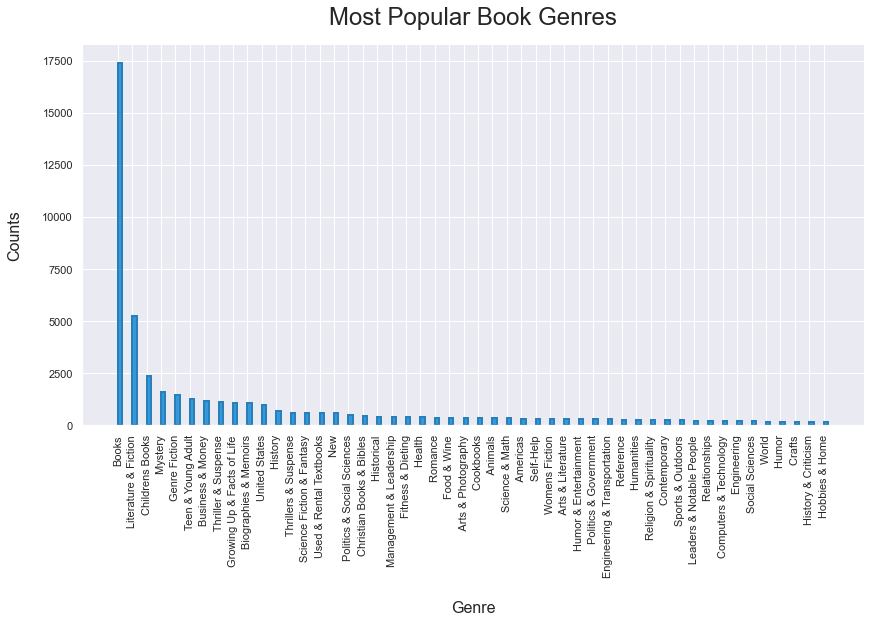

In [30]:
def make_bar_chart(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    #if attribute == 'Genre':
    #    dataset = dataset[dataset['Genre'] != '9999']
    if sort_index == False:
        xs = dataset[attribute].value_counts().index
        ys = dataset[attribute].value_counts().values
    else:
        xs = dataset[attribute].value_counts().sort_index().index
        ys = dataset[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs[:50], height=ys[:50], color=bar_color, edgecolor=edge_color, linewidth=2, align='edge', width=0.3)
    plt.xticks(rotation=90)
    
    
    
make_bar_chart(genre_df, 'Genre', title='Most Popular Book Genres', xlab='Genre', ylab='Counts')



In [31]:
# without split
genre_alltags_df = pd.DataFrame(data_with_meta['category'].tolist(), index=data_with_meta['asin']).stack()
genre_alltags_df = genre_alltags_df.reset_index([0, 'asin'])
genre_alltags_df.columns = ['asin', 'Genre']
genre_alltags_df['Genre'] = genre_alltags_df['Genre'].str.replace("'", '')
genre_alltags_df['Genre'] = genre_alltags_df['Genre'].str.replace('"', '')

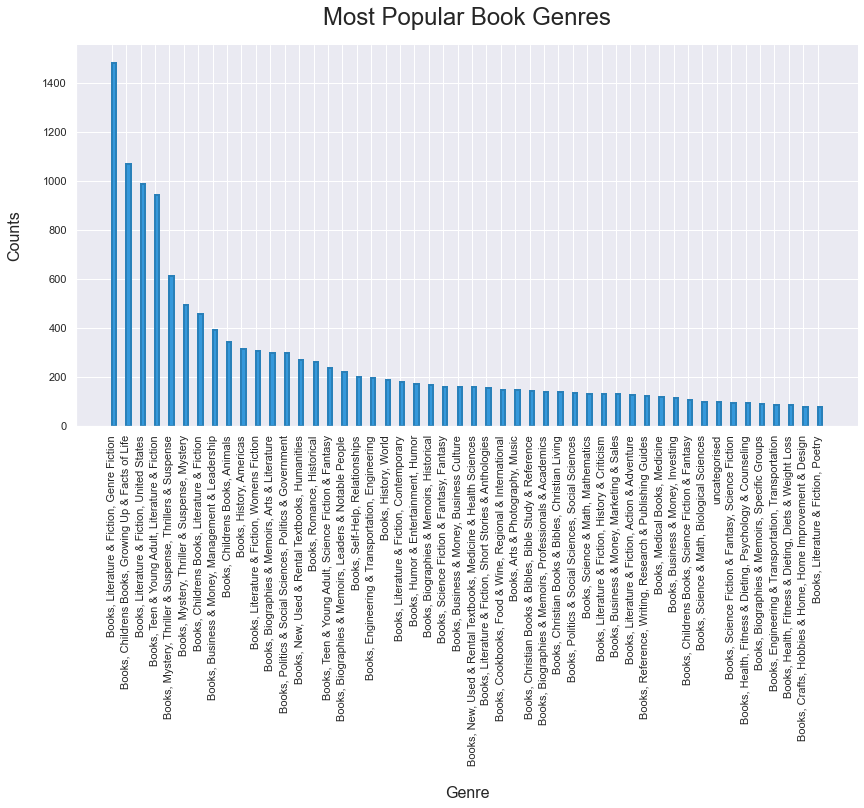

In [32]:
make_bar_chart(genre_alltags_df, 'Genre', title='Most Popular Book Genres', xlab='Genre', ylab='Counts')



In [59]:
def text_to_words(raw):
    # Function to convert a raw text to a string of words
    # The input is a single string (a raw text), and 
    # the output is a single string (a preprocessed text)

    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
   
    words = [w for w in words]
    
   
    return(" ".join(words))

In [60]:
# get processed description
data_with_meta['description_processed'] = data_with_meta['description'].map(text_to_words)


In [50]:
#data_with_meta.to_csv('/Users/jocelynpok/Downloads/recommender/data_with_meta.csv', index=False)

In [51]:
#data_with_meta = pd.read_csv('/Users/jocelynpok/Downloads/recommender/data_with_meta.csv')
#data_with_meta.head()


description                0
title                      0
asin                       0
category                   0
description_processed    656
dtype: int64

Some of the words that may be of interest in the top 10 most common words found in book descriptions include 'new','york' and 'times' suggesting that the inclusion of credentials whereby the book being on the New York Times' bestsellers list or having a review on the acclaimed media platform could be a strategy employed to increase book sales.

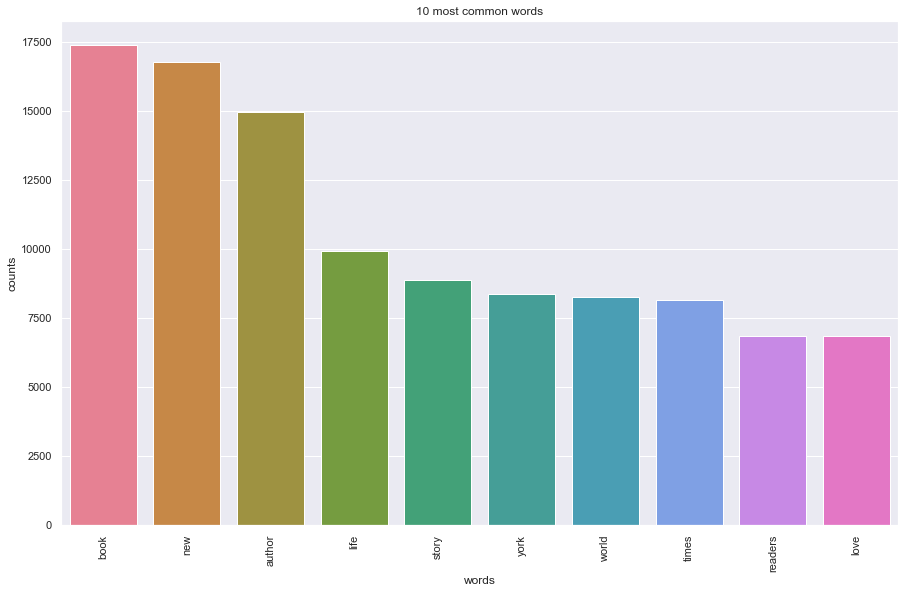

In [37]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data_with_meta['description_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [38]:
data_with_meta[data_with_meta['description_processed'].str.contains("new|york|times")]['description'][4]

'["`There\'s no resisting the appeal of King\'s thrillingly moody scenes of Dartmoor and her lovely evocations of its legends.\'New York Times Book Review `King not only provides a suitably generous array of things that go bump in the night, but suplies an explanation for all the skullduggery... that\'s at least as ingenious and plausible as Conan Doyle\'s own.\'Booklist. `The great marvel of King\'s series is that she\'s managed to preserve the integrity of Holmes\'s character and yet somehow conjure up a woman astute, edgy and compelling enough to be the partner of his mind as well as his heart\'Washington Post", \'Laurie King is a third-generation native of San Francisco, but since her marriage to an Anglo-Indian professor she has lived briefly on five continents. She and her husband have two children. They live mostly in California.\']'

In [39]:
data_with_meta[data_with_meta['description_processed'].str.contains("new|york|times")]['description'][131]

"['', 'Kathryn Lasky is a New York Times bestselling author of many acclaimed childrens and young adult books. Her picture book Sugaring Time was awarded a Newbery Honor. She has twice won the National Jewish Book Award, for her novel The Night Journey and her picture book Marven of the Great North Woods. Her book Elizabeth I: Red Rose of the House of Tudor was the most popular book in Scholastics bestselling Royal Diaries series. The Guardians of GaHoole was made into the Warner Bros. movie Legend of the Guardians. She lives in Cambridge, Massachusetts, with her husband. Visit her online at www.kathrynlasky.com.', '', '', '']"

## Exploratory Data Analysis

## Reviews that have corresponding book descriptions

In [73]:
user_review_for_books_have_desc = combined_latest[~combined_latest['asin'].isin(asin_no_desc_list)]

In [41]:
user_review_for_books_have_desc.shape

(1184948, 5)

To mitigate the cold start problem, whereby personalization for users with few interactions or even no interactions at all will prove challenging, only users with at least 5 interactions will be kept in the dataset.

In [42]:
users_interactions_count_desc_df = user_review_for_books_have_desc.groupby(['reviewerID', 'asin']).size().groupby('reviewerID').size()
print('# users: %d' % len(users_interactions_count_desc_df))
users_with_enough_interactions_desc_df = users_interactions_count_desc_df[users_interactions_count_desc_df >= 5].reset_index()[['reviewerID']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_desc_df))

# users: 598383
# users with at least 5 interactions: 33480


In [43]:
print('# of interactions: %d' % len(user_review_for_books_have_desc))
interactions_from_selected_users_desc_df = user_review_for_books_have_desc.merge(users_with_enough_interactions_desc_df, 
               how = 'right',
               left_on = 'reviewerID',
               right_on = 'reviewerID')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_desc_df))

# of interactions: 1184948
# of interactions from users with at least 5 interactions: 349581


In [44]:
# Save users with at least 5 interactions
#interactions_from_selected_users_desc_df.to_csv('/Users/jocelynpok/Downloads/recommender/interactions_from_selected_users_desc_df.csv', index_label=interactions_from_selected_users_desc_df.index.name)

The majority of the ratings are in the range of 4-5 stars. Recommending via quantitative ratings would yield other books with high ratings- which is the bulk of the books and that every other book is equally likely to be recommended and therefore other recommendation techniques should be explored.

/Users/jocelynpok/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



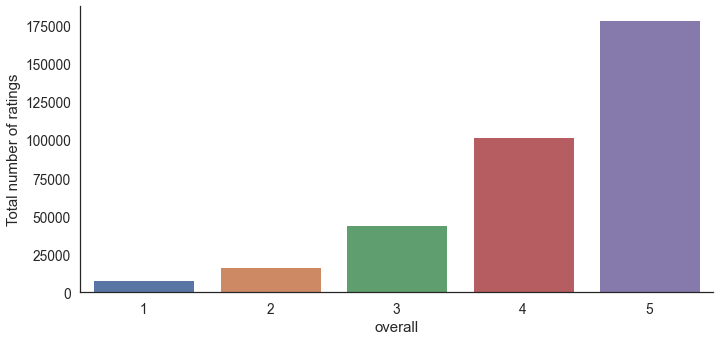

In [45]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=interactions_from_selected_users_desc_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [46]:
total_rows = interactions_from_selected_users_desc_df.shape[0]
interactions_from_selected_users_desc_df['word_count_reviews'] = np.nan
print("Cleaning and parsing the reviews...")

# Instantiate counter.
j = 0

for text in interactions_from_selected_users_desc_df['reviewText']:
    
    
    interactions_from_selected_users_desc_df['word_count_reviews'].values[j] = len(text_to_words(text).split())
    
    # If the index is divisible by 10000, print a message.
    if (j + 1) % 10000 == 0:
        print(f'Row {j + 1} of {total_rows}.')
    
    j += 1

Cleaning and parsing the reviews...
Row 10000 of 349581.
Row 20000 of 349581.
Row 30000 of 349581.
Row 40000 of 349581.
Row 50000 of 349581.
Row 60000 of 349581.
Row 70000 of 349581.
Row 80000 of 349581.
Row 90000 of 349581.
Row 100000 of 349581.
Row 110000 of 349581.
Row 120000 of 349581.
Row 130000 of 349581.
Row 140000 of 349581.
Row 150000 of 349581.
Row 160000 of 349581.
Row 170000 of 349581.
Row 180000 of 349581.
Row 190000 of 349581.
Row 200000 of 349581.
Row 210000 of 349581.
Row 220000 of 349581.
Row 230000 of 349581.
Row 240000 of 349581.
Row 250000 of 349581.
Row 260000 of 349581.
Row 270000 of 349581.
Row 280000 of 349581.
Row 290000 of 349581.
Row 300000 of 349581.
Row 310000 of 349581.
Row 320000 of 349581.
Row 330000 of 349581.
Row 340000 of 349581.


Reviews with overall rating of 1 have a higher median review word count compared to reviews with overall rating of 5.

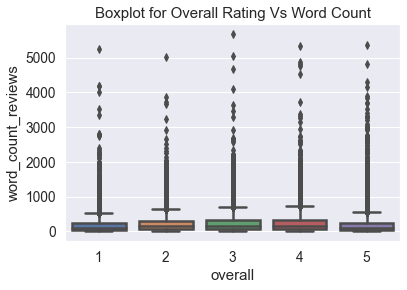

In [47]:
sns.boxplot(x="overall", y="word_count_reviews",data=interactions_from_selected_users_desc_df).set_title('Boxplot for Overall Rating Vs Word Count');

In [48]:
interactions_from_selected_users_desc_df.groupby('overall')['word_count_reviews'].describe()

,count,mean,std,min,25%,50%,75%,max
overall,,,,,,,,
1,8376.0,195.939589,271.148297,1.0,49.0,110.0,236.00,5259.0
2,16350.0,221.778104,239.804757,1.0,68.0,146.0,295.00,5026.0
3,44374.0,228.701943,227.062471,0.0,68.0,165.0,319.00,5687.0
4,101690.0,227.380804,222.474075,0.0,61.0,165.0,326.75,5322.0
5,178791.0,172.860787,214.451369,0.0,30.0,90.0,242.00,5358.0


In [49]:
## investigate the reviews with rating 1
ratings_1 = interactions_from_selected_users_desc_df[interactions_from_selected_users_desc_df['overall']==1]


In [50]:
ratings_1.iloc[5]['reviewText']

'Jodi Piccoult knows how to weave a tale, unfortunately this was not one of her best efforts.  So many reviews, I\'ll just say what it was that kept me from really enjoying this novel.  PLEASE NOTE THERE WILL BE PLOT REFERENCES\n\n1.  The characters were rather one dimensional, I liked Gus the best and felt I knew her the best  2. The sudden turning of Melanie against a best friend (even under these circumstances) was not in keeping with the flow of the characters and their 19 year "best friend" relationship nor did it seem to fit Melanie\'s character. Had it been Gus who was in the same situation, I think the reactions would have been totally different.  Melanie was so harsh she let in no light and thus I found her distasteful and her reactions unreasonable. I was especially aghast that she would find Em\'s diary which could have helped everyone heal, and she burned it!  Regardless of her grief, she comes across as a witch.  3. Chris\' father also responded in an uncharacteristically 

In [51]:
# Get processed reviewTest
interactions_from_selected_users_desc_df['reviewText_processed'] = interactions_from_selected_users_desc_df['reviewText'].map(text_to_words)

Using the CountVectorizer, the 10 most frequent words include 'like' and 'love', reflecting the positive sentiment of the negatively skewed rating distribution.

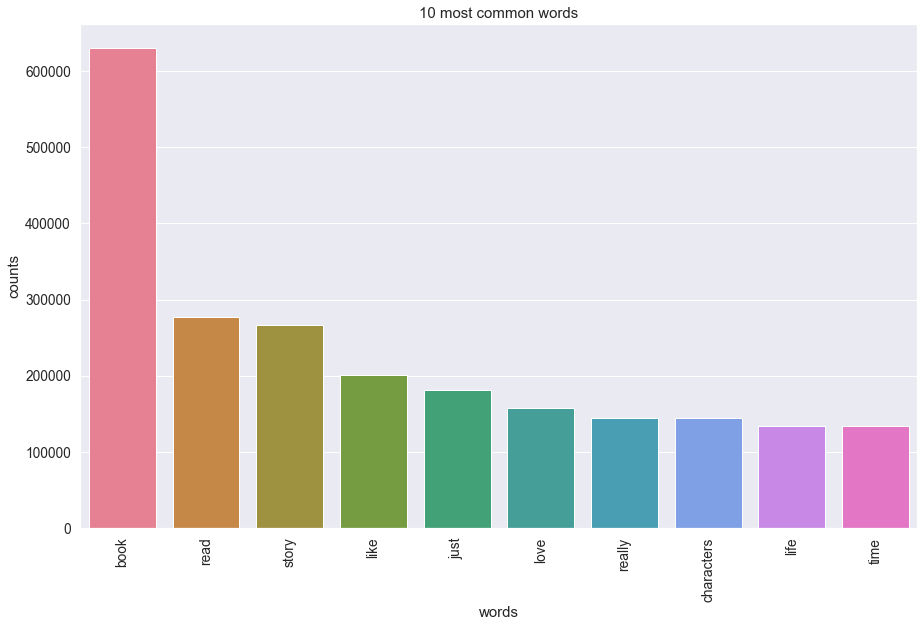

In [52]:
# Initialise the count vectorizer with the English stop words
count_vectorizer_reviews = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data_reviews = count_vectorizer_reviews.fit_transform(interactions_from_selected_users_desc_df['reviewText_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data_reviews, count_vectorizer_reviews)

In [53]:
interactions_from_selected_users_desc_ratingbygenre_df = interactions_from_selected_users_desc_df.copy()
interactions_category = pd.merge(interactions_from_selected_users_desc_ratingbygenre_df,data_with_meta[['asin','category']],on='asin', how='left')

A trend is observed whereby as a book gets more ratings, the average ratings tends to increase. If more people are reading a particular book, a sizeable amount of resource is likely to have been set aside by the publisher for marketing, which would mean that it’s gained traction in the literary sphere, and it will generally be highly rated.

Interestingly, the outlier with 986 reviews and average rating of 3.56 is Harper Lee's Go Set A Watchman. The sequel to her modern American classic, To Kill A Mockingbird was met with mixed reviews with her depiction of a revered symbol of justice and fairness as a flawed, bigoted hypocrite("Mixed early reviews for Harper Lee's Go Set A Watchman",2015). The distressing narrative is likely to have been disorienting for fans of the 1960 literacy classic contributing to the observed ratings for this much anticipated sequel(Kakutani,2015)

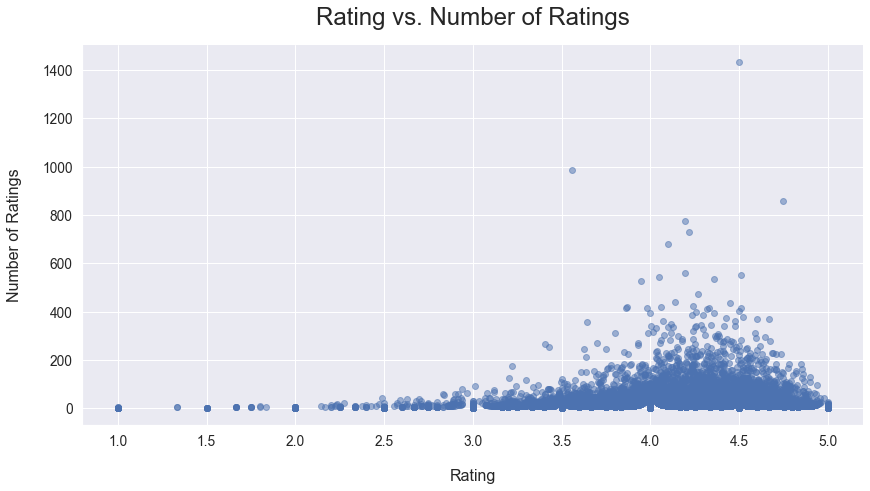

In [54]:
ratings_df = pd.DataFrame()
ratings_df['Mean_Rating'] = interactions_category.groupby('asin')['overall'].mean().values
ratings_df['Num_Ratings'] = interactions_category.groupby('asin')['overall'].count().values


fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(ratings_df['Mean_Rating'], ratings_df['Num_Ratings'], alpha=0.5);



In [79]:
outlier_ratings_df = ratings_df.loc[(ratings_df['Num_Ratings']==986),:]
outlier_ratings_df

,Mean_Rating,Num_Ratings
13099,3.560852,986


In [80]:
outlier_ratings_df = ratings_df.loc[(ratings_df['Num_Ratings']>800)&(ratings_df['Num_Ratings']<1200),:]
outlier_ratings_df

,Mean_Rating,Num_Ratings
1007,4.746791,857
13099,3.560852,986


In [56]:
ratings_new_df= interactions_category.groupby(['asin']).agg(['mean', 'count'])

ratings_new_df.head()

overall       word_count_reviews      
                mean count               mean count
asin                                               
0002005883  4.037815   238         225.042017   238
0006153607  3.000000     2         287.000000     2
0006388477  3.600000     5         321.600000     5
0006482619  5.000000     2        1178.500000     2
0006510868  4.113636    44         161.931818    44

In [82]:
ratings_new_df[ratings_new_df.index.isin(['0062409883'])]

overall       word_count_reviews      
                mean count               mean count
asin                                               
0062409883  3.560852   986         167.002028   986

In [57]:
total_by_asin = pd.pivot_table(interactions_category, index = 'asin', values = 'overall', aggfunc='count')

In [58]:
total_by_asin.head()
total_by_asin.reset_index()
total_by_asin[total_by_asin['overall'] == 986]

,overall
asin,
0062409883,986


In [85]:
interactions_category['category'] = interactions_category['category'].str.replace("'", '')

Books in the 'Politics & Government' genre generally get high mean ratings while books in the 'Intellectual Property' domain tend to get lower average ratings.

In [86]:
values = defaultdict(list)
for ind, row in interactions_category.iterrows():
    for genre in row['category'].split(','):
        values[genre].append(row['overall'])
        
        
genre_lst, rating_lst = [], []
for key, item in values.items():
    if key not in [0, 1]:
        genre_lst.append(key)
        rating_lst.append(np.mean(item))
        
        
genres_with_ratings = pd.DataFrame([genre_lst, rating_lst]).T
genres_with_ratings.columns = ['Genre', 'Mean_Rating']

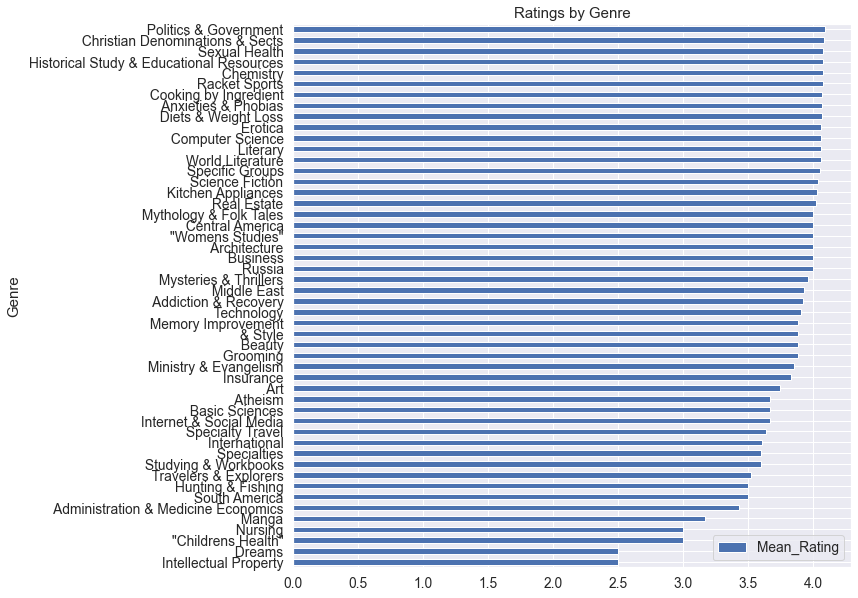

In [88]:
genres_with_ratings.sort_values(by='Mean_Rating', ascending=True)[:50].plot(y='Mean_Rating',x='Genre',kind='barh', figsize=(10,10), color='b', 
                                  title='Ratings by Genre');

In [89]:
values = defaultdict(list)
for ind, row in interactions_category.iterrows():
    for genre in row['category'].split('|'):
        values[genre].append(row['overall'])
        
        
genre_alltags_lst, rating_alltags_lst = [], []
for key, item in values.items():
    if key not in [0, 1]:
        genre_alltags_lst.append(key)
        rating_alltags_lst.append(np.mean(item))
        
        
genres_with_ratings = pd.DataFrame([genre_alltags_lst, rating_alltags_lst]).T
genres_with_ratings.columns = ['Genre_all_tags', 'Mean_Rating']

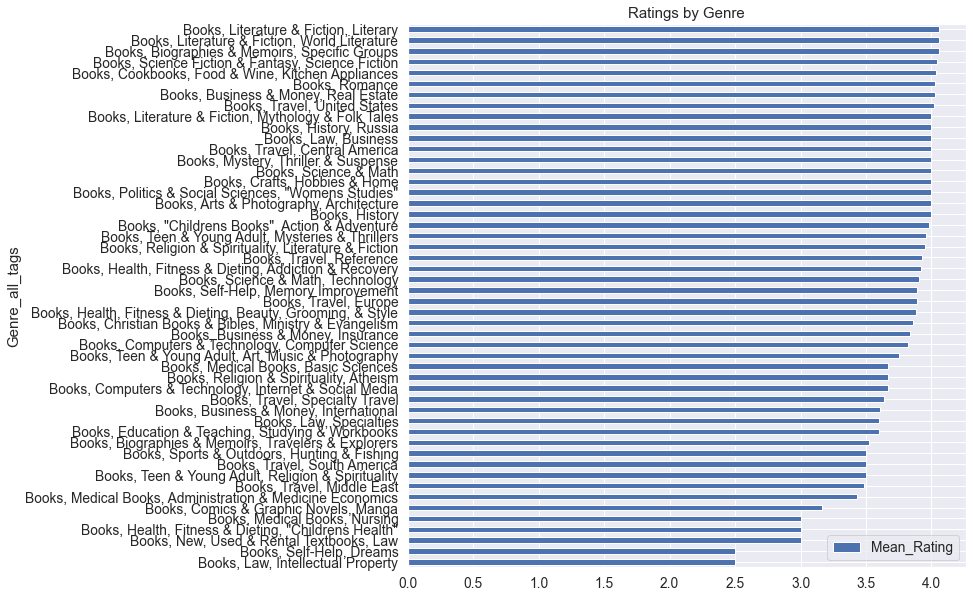

In [90]:
genres_with_ratings.sort_values(by='Mean_Rating', ascending=True)[:50].plot(y='Mean_Rating',x='Genre_all_tags',kind='barh', figsize=(10,10), color='b', 
                                  title='Ratings by Genre');

## Model fit and evaluation

One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using **Cross-validation** techniques. The **holdout** approach is adopted here, in which a random data sample (20% in this case) is kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the **test set**.

The models will be evaluated using the **Top-N accuracy metric**. It is a measure of the frequency of the predicted class falling in the top N values of the softmax distribution. Users are provided with a ranked list of N items they will likely be interested in, in order to encourage views and purchases.This can circumvent the accuracy paradox. A person looking through an e-commerce platform is looking for diversity, novelty, coverage, serendipity and relevance.


The accuracy of the top recommendations will be evaluated as follows:
1. For each item that each user has interacted in the test set, *interactions_test_indexed_df*-indexing by reviewerID :
    - Sample 100 other items that the user has never interacted
    - A ranked list of recommended items consisting of one interacted item and 100 items that the user has not interacted with yet is produced by the model
    - The Top-N accuracy metric for each user and the interacted item from the recommendations ranked list is computed
2. The global Top-N accuracy metric is aggregated

To evaluate the top-10 recommendations, hit rate is used. If a user rated one of the top-5/10 that was recommended, we consider it is a “hit”.

The process of computing hit rate for a single user:
1. Find all items in the user’s history in the testing data.
2. Loop through each interacted item in testing data, filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
3. If the interacted item appear in the top 5/10 recommendations, it is a hit. If not, it’s not a hit.

In [19]:
#interactions_from_selected_users_desc_df = pd.read_csv('/Users/jocelynpok/Downloads/recommender/interactions_from_selected_users_desc_df.csv', index_col='Unnamed: 0')

In [20]:
interactions_train_df, interactions_test_df = train_test_split(interactions_from_selected_users_desc_df,
                                   stratify=interactions_from_selected_users_desc_df['reviewerID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 279664
# interactions on Test set: 69917


In [21]:
#Indexing by reviewerID to speed up the searches during evaluation
interactions_full_indexed_df = interactions_from_selected_users_desc_df.set_index('reviewerID')
interactions_train_indexed_df = interactions_train_df.set_index('reviewerID')
interactions_test_indexed_df = interactions_test_df.set_index('reviewerID')

In [22]:
def get_items_interacted(reviewer_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[reviewer_id]['asin']
    #print(interacted_items)
    #print(set(interacted_items))
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [35]:
#data_with_meta = pd.read_csv('/Users/jocelynpok/Downloads/recommender/data_with_meta.csv')

In [24]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(user_review_for_books_have_desc['asin'])
        #print(all_items)
        non_interacted_items = all_items - interacted_items
        seedValue = random.randrange(sys.maxsize)
        random.seed(seedValue)
        #random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['asin']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['asin'])
        else:
            person_interacted_items_testset = set([interacted_values_testset['asin']])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)
        #print(person_recs_df.columns)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            #print(item_id)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS) 
                                                                          #seed=item_id%(2**32))
            
            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['asin'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['asin'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(tqdm(list(interactions_test_indexed_df.index.unique().values))):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

## Popularity Model

The underlying algorithm is to recommend books that are popular, regardless of features of items or feedback from the users. This method is useful for cold start (new customers) scenarios where limited information of the user or item is known. To implement the baseline model, the books are sorted by number of reviews in descending order, and then top k is treated as a recommended list indiscriminately for all customers.


In [9]:
#filter books with at least 50 ratings

users_50_df=interactions_from_selected_users_desc_df.groupby("asin").filter(lambda x:x['overall'].count() >=50)

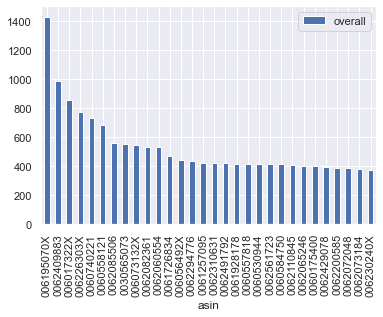

In [10]:
popular_books = pd.DataFrame(users_50_df.groupby('asin')['overall'].count())
most_popular = popular_books.sort_values('overall', ascending=False)
#.reset_index()
most_popular.head(30).plot(kind = "bar");

In [11]:
most_popular.reset_index(inplace=True)
most_popular.head()


,asin,overall
0,006195070X,1434
1,0062409883,986
2,006017322X,857
3,006226303X,776
4,0060740221,730


In [23]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['asin'].isin(items_to_ignore)]\
                               .sort_values('overall', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'asin', 
                                                          right_on = 'asin')[['overall', 'asin', 'title']]

            
        return recommendations_df
    
popularity_model = PopularityRecommender(most_popular, interactions_from_selected_users_desc_df)

In [26]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)



Evaluating Popularity recommendation model...


/Users/jocelynpok/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




33479 users processed


In [27]:
pop_detailed_results_df.to_csv('../results/pop_detailed_results_df.csv', index_label=pop_detailed_results_df.index.name)

In [28]:
pickle.dump(pop_global_metrics, open('../results/pop_global_metrics.pkl', 'wb'))

In [29]:
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.4130755038116624, 'recall@10': 0.5420856158015933}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
497,57,74,199,0.286432,0.371859,A2F6N60Z96CAJI
1404,27,40,92,0.293478,0.434783,AHUT55E980RDR
434,7,15,67,0.104478,0.223881,A320TMDV6KCFU
421,9,14,65,0.138462,0.215385,A2TX179XAT5GRP
1001,24,31,64,0.375000,0.484375,A3U7ELIED4WP4R
67,11,17,58,0.189655,0.293103,A1K1JW1C5CUSUZ
564,12,16,50,0.240000,0.320000,A14I311IIUMBWC
1537,17,23,49,0.346939,0.469388,A2VQNF5HS9KJDD
939,9,14,47,0.191489,0.297872,AFVZXHIUSXINA
1591,17,22,46,0.369565,0.478261,A22B13EJTZKCTM


It achieved the **Recall@5** of **0.413**, which means that about **41%** of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And **Recall@10** of **0.542** indicating that **54%** of the interacted items in the test set were ranked by Popularity model among the top-10 items.

## Personalisation

In the case of e-commerce websites, personalisation is a technique of dynamically tailoring your content based on the needs of each user. Some benefits include:

1. Enhancing customer experience. Relevant content is shown, reducing the clutter
2. Marketing opportunities. Relevant products based on preference can increase product visibility, leading to increase cross-sell/up-sell opportunities
3. Increased sales. Personalised experience often results in increased basket size and more frequent purchases.
4. Increased customer loyalty. Customer retention is imperative in the digital domain. 

## Content-Based Filtering Model

Content-based filtering leverage on description or attributes from items the user has interacted to recommend similar items. It depends only on the users' previous choices, making this method robust to avoid the cold-start problem. 

In order to have personalized recommendations from a content-based model, the list of book interactions for each user is retrieved. 
For each book interaction, the similarity of the book compared to all other books is obtained using the tfidf features matrix, where the vector for each document is represented as the computed TF-IDF weights 

The cosine similarity between the user profile and all item profiles is computed to establish each user's preference. This is most useful in word vectorization because normalizing the data makes a long document comparable to a short document. Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them. It is the dot product of two vectors divided by the product of the magnitude of each vector. As the dot product is divided by the magnitude, data is normalised and only the angle difference is measured. The cosine similarity of each book to each profile is calculated. The cosine of a 0 degree angle is 1, therefore the closer to 1 the cosine similarity is, the more similar the items are.

$$
sim(A,B) = cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{\left\| \vec{A}\right\| \left\| \vec{B}\right\| }$$

In [61]:
#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords.words('english'))

item_ids = data_with_meta['asin'].tolist()
tfidf_matrix = vectorizer.fit_transform(data_with_meta['description_processed'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<17502x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1629307 stored elements in Compressed Sparse Row format>

In [44]:
#pickle.dump(tfidf_matrix, open('/Users/jocelynpok/Downloads/recommender/tfidf_matrix.pkl', 'wb'))

In [62]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['asin'])
    
    user_item_strengths = np.array(interactions_person_df['overall']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_from_selected_users_desc_df[interactions_from_selected_users_desc_df['asin'] \
                                                   .isin(data_with_meta['asin'])].set_index('reviewerID')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [63]:
user_profiles = build_users_profiles()
len(user_profiles)

33480

### Creation of user profile walkthrough

To model the user profile, the average of all the book profiles that the user has reviewed is taken. The average is weighted by the rating strength, in other words, the books the user has given highest ratings for will have a higher strength in the final user profile.
The profiles of all the users are created using the build_user_profile function.

In [70]:
#getting all reviewers and books that they have reviewed
interactions_with_index_df = interactions_from_selected_users_desc_df[interactions_from_selected_users_desc_df['asin'] \
                                                   .isin(data_with_meta['asin'])].set_index('reviewerID')

In [71]:
interactions_with_index_df.head()
#{'0060149361', '0060156953', '006056346X', '0060563745'}

,asin,overall,review_Datetime,reviewText,word_count_reviews,reviewText_processed
reviewerID,,,,,,
A0334855HN6E38CXWXZR,0060149361,5,2015-05-12,another good mystery novel featuring Chee and ...,8.0,another good mystery novel featuring chee and ...
A0334855HN6E38CXWXZR,0060153962,5,2015-05-12,another good mystery featuring the Navaho Tri...,11.0,another good mystery featuring the navaho trib...
A0334855HN6E38CXWXZR,0060156953,5,2015-05-12,another great book by the late Tony Hillerman ...,13.0,another great book by the late tony hillerman ...
A0334855HN6E38CXWXZR,006056346X,5,2015-05-12,great detail of life in the 4 Corners area wov...,12.0,great detail of life in the corners area woven...
A0334855HN6E38CXWXZR,0060563745,5,2015-04-09,Great detail about the Four Corners area and N...,15.0,great detail about the four corners area and n...


The profile for reviewerID A0334855HN6E38CXWXZR is built in a series of steps.

In [73]:
#user A0334855HN6E38CXWXZR
interactions_A0334855HN6E38CXWXZR_df = interactions_with_index_df.loc['A0334855HN6E38CXWXZR']
interactions_A0334855HN6E38CXWXZR_df.head()


,asin,overall,review_Datetime,reviewText,word_count_reviews,reviewText_processed
reviewerID,,,,,,
A0334855HN6E38CXWXZR,0060149361,5,2015-05-12,another good mystery novel featuring Chee and ...,8.0,another good mystery novel featuring chee and ...
A0334855HN6E38CXWXZR,0060153962,5,2015-05-12,another good mystery featuring the Navaho Tri...,11.0,another good mystery featuring the navaho trib...
A0334855HN6E38CXWXZR,0060156953,5,2015-05-12,another great book by the late Tony Hillerman ...,13.0,another great book by the late tony hillerman ...
A0334855HN6E38CXWXZR,006056346X,5,2015-05-12,great detail of life in the 4 Corners area wov...,12.0,great detail of life in the corners area woven...
A0334855HN6E38CXWXZR,0060563745,5,2015-04-09,Great detail about the Four Corners area and N...,15.0,great detail about the four corners area and n...


A sparse matrix of shape 5 x 5000 is retrieved for user A0334855HN6E38CXWXZR for the 5 books that the user has reviewed. 

In [74]:
# item profile for A0334855HN6E38CXWXZR
A0334855HN6E38CXWXZR_item_profiles = get_item_profiles(interactions_A0334855HN6E38CXWXZR_df['asin'])
A0334855HN6E38CXWXZR_item_profiles.shape

(5, 5000)

In [75]:
A0334855HN6E38CXWXZR_item_strengths = np.array(interactions_A0334855HN6E38CXWXZR_df['overall']).reshape(-1,1)
A0334855HN6E38CXWXZR_item_strengths.shape

(5, 1)

In [76]:
A0334855HN6E38CXWXZR_item_strength_sum = np.sum(np.array(interactions_A0334855HN6E38CXWXZR_df['overall']).reshape(-1,1))
A0334855HN6E38CXWXZR_item_strength_sum

25

In [79]:
sum_prof_mul_strength = np.sum(A0334855HN6E38CXWXZR_item_profiles.multiply(A0334855HN6E38CXWXZR_item_strengths), axis=0)

In [80]:
sum_prof_mul_strength.shape

(1, 5000)

In order to accurately user preference, a weight is imposed using the rating given by A0334855HN6E38CXWXZR such that the books that  A0334855HN6E38CXWXZR has given highest ratings for will have a higher strength in the final user profile of A0334855HN6E38CXWXZR. The final profile returned is the weighted average of A0334855HN6E38CXWXZR item profiles.

In [81]:
A0334855HN6E38CXWXZR_item_strengths_weighted_avg = sum_prof_mul_strength / A0334855HN6E38CXWXZR_item_strength_sum
A0334855HN6E38CXWXZR_profile_norm = sklearn.preprocessing.normalize(A0334855HN6E38CXWXZR_item_strengths_weighted_avg)

In [144]:
A0334855HN6E38CXWXZR_profile_norm.shape

(1, 5000)

The profile of A0334855HN6E38CXWXZR is a unit vector of 5000 length. The value in each position represents how relevant is a token (unigram or bigram) for the user.
It appears that the top relevant tokens represents A0334855HN6E38CXWXZR interests in mystery and crime novels.

In [82]:
A0334855HN6E38CXWXZR_profile = user_profiles['A0334855HN6E38CXWXZR']
print(A0334855HN6E38CXWXZR_profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['A0334855HN6E38CXWXZR'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,mystery,0.291648
1,honored,0.219096
2,grand,0.218524
3,writers america,0.193982
4,nonfiction,0.187559
5,edgar,0.164499
6,joe,0.160367
7,jim,0.159026
8,awards,0.157022
9,police,0.143778


In [64]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['asin', 'overall']) \
                                    .head(topn)
        
        recommendations_df = recommendations_df.merge(data_with_meta, how = 'left', 
                                                    left_on = 'asin', 
                                                    right_on = 'asin')[['asin', 'overall', 'title']].drop_duplicates()


        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'asin', 
                                                          right_on = 'asin')[['overall', 'asin', 'title']]

        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(interactions_from_selected_users_desc_df)

In [86]:
A0334855HN6E38CXWXZR_recs_df = content_based_recommender_model.recommend_items('A0334855HN6E38CXWXZR', 
                                               items_to_ignore=get_items_interacted('A0334855HN6E38CXWXZR', 
                                                                                    interactions_train_indexed_df), 
                                               topn=10)

In [87]:
A0334855HN6E38CXWXZR_recs_df

,asin,overall,title
0,0060082968,0.869363,"Thief of Time, A Low Price"
1,0060815132,0.869363,The Fly on the Wall CD Low Price
2,0060753382,0.869363,The Leaphorn & Chee Novels
3,0060563478,0.869363,The Shape Shifter
4,0060820780,0.832817,"Tony Hillerman: Leaphorn, Chee, and More: The ..."
5,0060815140,0.832817,The Blessing Way
6,0060164786,0.783659,The Jim Chee Mysteries: Three Classic Hillerma...
7,0060093889,0.773722,The Wailing Wind
8,0060792817,0.653777,Tony Hillerman: The Leaphorn and Chee Audio Tr...
9,0061492221,0.380195,Odds Against Low Price CD


In [ ]:
#append asin to url to view product detail
#https://www.amazon.com/dp/

In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)


In [ ]:
cb_detailed_results_df.to_csv('../results/cb_detailed_results_df.csv', index_label=cb_detailed_results_df.index.name)

In [ ]:
pickle.dump(cb_global_metrics, open('../results/cb_global_metrics.pkl', 'wb'))

In [ ]:
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

In [3]:
cb_global_metrics_infile = open('../results/cb_global_metrics.pkl','rb')
cb_global_metrics = pickle.load(cb_global_metrics_infile)
cb_global_metrics

{'modelName': 'Content-Based',
 'recall@5': 0.8985940472274268,
 'recall@10': 0.9115808744654376}

In [4]:
cb_results = pd.read_csv('../results/cb_detailed_results_df.csv', index_col='Unnamed: 0')
cb_results.head(10)

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
497,52,58,199,0.261307,0.291457,A2F6N60Z96CAJI
1404,35,37,92,0.380435,0.402174,AHUT55E980RDR
434,28,28,67,0.417910,0.417910,A320TMDV6KCFU
421,20,26,65,0.307692,0.400000,A2TX179XAT5GRP
1001,35,40,64,0.546875,0.625000,A3U7ELIED4WP4R
67,12,16,58,0.206897,0.275862,A1K1JW1C5CUSUZ
564,29,29,50,0.580000,0.580000,A14I311IIUMBWC
1537,23,26,49,0.469388,0.530612,A2VQNF5HS9KJDD
939,18,21,47,0.382979,0.446809,AFVZXHIUSXINA
1591,27,29,46,0.586957,0.630435,A22B13EJTZKCTM


The content-based model achieved the **Recall@5** of 0.898, which means that about **89%** of interacted items in test set were ranked by model among the top-5 items (from lists with 100 random items). And **Recall@10** of 0.911 indicating that **91%** of the interacted items in the test set were ranked by model among the top-10 items.

## Collaborative filtering

Collaborative filtering produces recommendations based on the knowledge of users’ preference to items in order to recommend items.

CF can be divided into *Memory-Based Collaborative Filtering* and *Model-Based Collaborative Filtering*.

Model-based CF methods are based on matrix factorization (MF). MF methods are used as an unsupervised learning method for latent variable decomposition and dimensionality reduction. They can handle scalability and sparsity problems better than Memory-based CF.

From a high level, matrix factorisation decomposes the interaction matrix into two matrices (user and item), such that upon multiplication, the original interaction matrix is retained.

In case of recommendation systems, the matrix factorization algorithm will decompose the interaction/rating matrix between users and items matrix into user and item feature matrix which is also known as embeddings.

Typically user/item embeddings capture latent features about attributes of users and item respectively. Essentially, latent features are the representation of user/item in an arbitrary space which represents how a user rate a book.For example, people who like Technology-related books would have similar embeddings with those that prefer software-related books but are probably further away from those that are fond of Mystery novels in the vector space. 

The goal of MF is to learn latent user preferences and item attributes from known ratings. Those variable are then used to predict unknown ratings through the dot product of the latent features of users and items.
Matrix factorization restructures the user-item matrix into a low-rank matrix. You can represent it by the multiplication of two low-rank matrices, where the rows contain a vector of latent variables. This matrix should approximate the original matrix, as closely as possible, by multiplying the low-rank matrices together. The missing entries in the original matrix can subsequently be predicted.



We have a set of 𝑀 books, or items (𝑀=17502 in the dataset). We also have 𝑁
users. For each item, we’d like to find a 𝐷 dimensional factor composition (book profile above) to describe the item. What we observe is the 𝑁×𝑀 ratings matrix 𝑅 provided by the users. Entry 𝑅𝑖𝑗 is the rating user 𝑖 gave to item 𝑗. Many of these entries may be missing, since most users will not have rated all 17502 movies. As observed below, users_items_pivot_matrix is a sparse matrix. 

The objective is to fill in the missing values with predicted ratings based on the latent variables 𝑈 and 𝑉.

Suppose we are seeking to recommend books using a model which infers five latent factors, 𝑉𝑗 for 𝑗=1,2,3,4,5. Assuming the five latent factors capture the book profile as follows: moody, light-hearted, conflict, dialogue, and budget. Then for a particular user 𝑖, we infer a preference vector 𝑈𝑖=[0.5,0.1,1.5,1.1,0.3]. Also, for a particular item 𝑗, we infer these values for the latent factors: 𝑉𝑗=[0.5,1.5,1.25,0.8,0.9]. Using the dot product as the prediction function, we would calculate 3.425 as the ranking for that item, which is more or less a neutral preference given our 1 to 5 rating scale.
$$0.5×0.5+0.1×1.5+1.5×1.25+1.1×0.8+0.3×0.9=3.425$$

In [25]:
users_items_pivot_matrix_df = interactions_train_df.pivot(index='reviewerID', 
                                                          columns='asin', 
                                                          values='overall').fillna(0)

users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()

In [26]:
users_items_pivot_matrix_na= np.array(interactions_train_df.pivot(index = 'reviewerID', columns ='asin', values = 'overall'))

In [27]:
user_ids = users_items_pivot_matrix_df.index.values

The global mean baseline will be used as a reference from which to evaluate the 2 approaches that will be explored. Wherever a missing value is observed, we’ll fill it in with the mean of all observed ratings.

In [97]:
def global_mean_baseline(pivot_matrix):
    nan_mask = np.isnan(pivot_matrix)
    pivot_matrix[nan_mask] = pivot_matrix[~nan_mask].mean()
    predicted = pivot_matrix
    return predicted

In [98]:
global_mean_baseline_preds = global_mean_baseline(users_items_pivot_matrix_na)

Collaborative Filtering can be formulated by approximating a matrix X by using Singular Value Decomposition (SVD).SVD can be expressed as:
$X = USV^T$, where U represents feature vectors of the users, V represents feature vectors of the items and the elements on the diagonal of S are known as singular values.

A prediction can be made by taking the dot product of U, S and $V^T$.

In [28]:
U, sigma, Vt = svds(users_items_pivot_matrix, k= 10)
sigma = np.diag(sigma)
predicted_ratings_10 = np.dot(np.dot(U, sigma), Vt) 

In [29]:
cf_preds_10_df = pd.DataFrame(predicted_ratings_10, 
                           columns = users_items_pivot_matrix_df.columns, 
                           index=user_ids).transpose()
cf_preds_10_df.head(10)

,A0334855HN6E38CXWXZR,A047816347FS2EFQ6VEY,A0509331D028ORDMIVI6,A0598193QWF1LXNNCV3O,A0762685MUUL2678STKH,A10074U9M272RL,A1008GFLTBL76H,A100K9CYLH1CGT,A100OJ8LFVPMPT,A100UD67AHFODS,...,AZZ26WCXRPFJX,AZZ4GD20C58ND,AZZ5ASC403N74,AZZ6TEDVBDIGD,AZZCH5JYCUTQS,AZZKNBQAO4Y9Z,AZZV9PDNMCOZW,AZZVZL4QEHEHO,AZZXCFBNEWIBQ,AZZY4E6QPTBVP
asin,,,,,,,,,,,,,,,,,,,,,
0002005883,0.015436,0.008531,0.019609,0.014526,0.005330,0.045731,0.047665,0.035334,0.000781,0.018783,...,0.006059,0.055174,0.000435,0.001654,0.006287,0.076087,0.031732,0.000822,0.006430,0.002278
0006153607,0.000038,0.000004,0.000102,0.000037,0.000007,-0.000017,0.000055,-0.000027,0.000002,0.000037,...,-0.000019,0.000095,-0.000001,0.000005,0.000011,0.000061,0.000045,0.000001,-0.000010,0.000003
0006388477,0.000144,0.000007,0.000215,0.000102,0.000042,0.000001,0.000673,-0.000055,0.000007,0.000185,...,-0.000137,0.001487,-0.000010,0.000021,0.000051,0.000262,0.000091,0.000004,-0.000038,0.000018
0006482619,0.000214,-0.000071,0.000153,0.000071,0.000044,-0.000263,0.000496,-0.000022,0.000021,0.000473,...,-0.000237,0.000901,-0.000050,0.000055,0.000103,0.001713,-0.000048,0.000007,-0.000055,0.000019
0006510868,0.002607,0.001158,0.006965,0.003031,-0.000085,0.003580,0.004834,0.001222,0.000081,0.001867,...,0.000062,0.006029,0.000418,0.000398,0.000753,0.003402,0.005309,0.000151,0.000118,0.000354
0007108451,0.000234,0.000029,0.000330,0.000171,0.000061,0.000059,0.002273,-0.000302,0.000003,0.000198,...,-0.000039,0.005600,-0.000007,0.000028,0.000069,-0.000865,0.000091,0.000004,-0.000106,0.000025
0007115865,0.004554,0.001099,0.014809,0.005302,-0.000281,0.000106,0.004114,-0.002384,0.000154,0.003185,...,0.004940,0.003869,-0.000197,0.000725,0.001170,0.003626,0.007794,0.000156,-0.000565,0.000200
0007145608,0.001544,0.000147,0.001964,0.001055,-0.000132,0.000397,0.009361,-0.000656,0.000069,0.001959,...,-0.001746,0.021601,0.000084,0.000260,0.000558,0.001778,0.000813,0.000085,-0.000466,0.000115
0007197799,0.000086,0.000012,0.000152,0.000068,-0.000032,0.000004,0.000201,0.000002,0.000005,0.000119,...,-0.000021,0.000358,0.000073,0.000014,0.000032,0.000363,0.000076,0.000016,-0.000014,0.000023


Probabilistic Matrix Factorization (PMF) takes a Bayesian perspective by adopting a probabilistic approach to collaborative filtering. The ratings 𝑅 are modeled as draws from a Gaussian distribution. The mean for 𝑅𝑖𝑗 is 𝑈𝑖𝑉𝑇𝑗.The precision 𝛼 is a fixed parameter that reflects the uncertainty of the estimations; the normal distribution is commonly reparameterized in terms of precision, which is the inverse of the variance. Complexity is controlled by placing zero-mean spherical Gaussian priors on 𝑈 and 𝑉. Each row of 𝑈 is drawn from a multivariate Gaussian with mean 𝜇=0 and precision which is some multiple of the identity matrix 𝐼. Those multiples are 𝛼𝑈 for 𝑈 and 𝛼𝑉 for 𝑉. The model is defined by:



![title](../images/pmf.png)

Given small precision parameters, the priors on 𝑈 and 𝑉 ensure our latent variables do not grow too far from 0. This prevents overly strong user preferences and item factor compositions from being learned. This is commonly known as complexity control, where the complexity of the model here is measured by the magnitude of the latent variables. Controlling complexity like this helps prevent overfitting, which allows the model to generalize better for unseen data. Point estimates obtained from our data will be used to choose appropriate values for 𝛼𝑈,𝛼𝑉 and 𝛼.

Functions for calculating the MAP and performing sampling on our PMF model will be needed. Maximizing the log-posterior over book and user feature vectors with hyperparameters (the observation noise variance 𝛼 and prior variances $𝛼_𝑈$ and $𝛼_𝑉$ ) kept fixed is equivalent to minimizing the sum-of-squared errors objective function with quadratic regularization terms, where $𝜆_𝑈$=$𝛼_𝑈$/𝛼, $𝜆_𝑉$=$𝛼_𝑉$/𝛼 and $‖⋅‖^{2}$𝐹𝑟𝑜 denotes the Frobenius norm. Minimizing this objective function gives a local minimum, which is essentially a maximum a posteriori (MAP) estimate.


![title](../images/objective_function.png)

For user 𝑖 and book 𝑗, a prediction is generated by drawing from $N$($𝑈_𝑖$$𝑉^𝑇_𝑗$,𝛼).To generate predictions from the sampler, we generate an 𝑅 matrix for each 𝑈 and 𝑉 sampled, then we combine these by averaging over the 𝐾
samples.


![title](../images/R_matrix.png)

To ensure the MAP estimate obtained is reasonable, the RMSE will be computed on the predicted ratings obtained from the MAP values of 𝑈 and 𝑉. A function is defined for generating the predicted ratings 𝑅 from 𝑈
and 𝑉. We ensure the actual rating bounds are enforced by setting all values below 1 to 1 and all values above 5 to 5.

The steps are outlined in a separate notebook, PMF.ipynb.

In [101]:
pmf_map_preds = load('/Users/jocelynpok/Downloads/recommender/map_preds.npy')

In order to evaluate the different approaches to obtain predictions, the root mean squared error will be used. RMSE can be thought of as the standard deviation of our predictions from the actual user preferences.

Based on the results obtained, the predictions obtained from using SVD obtained the lowest RMSE score of 0.10. The Scipy implementation of SVD will be chosen, given the established scalability and speed$^1$. Furthermore, MAP only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. 

In [102]:
baseline_rmse = sqrt(mean_squared_error(users_items_pivot_matrix, global_mean_baseline_preds))
svd_rmse = sqrt(mean_squared_error(users_items_pivot_matrix, predicted_ratings_10))
pmf_map_rmse = sqrt(mean_squared_error(users_items_pivot_matrix, pmf_map_preds))

# Print report.
print('baseline RMSE: %.2f' % baseline_rmse)
print('svd RMSE:  %.2f' % svd_rmse)
print('pmf MAP RMSE: %.2f' % pmf_map_rmse)

baseline RMSE: 4.22
svd RMSE:  0.10
pmf MAP RMSE: 1.03


In [30]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'overall'})

        # Recommend the highest predicted rating books that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['asin'].isin(items_to_ignore)] \
                               .sort_values('overall', ascending = False) \
                               .head(topn)
        recommendations_df = recommendations_df.merge(data_with_meta, how = 'left', 
                                                      left_on = 'asin', 
                                                      right_on = "asin")[['overall',
                                                                              'asin', 'title']].drop_duplicates()

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')


            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'asin', 
                                                          right_on = 'asin')[['overall', 'asin', 'title']]

        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_10_df, interactions_from_selected_users_desc_df)

In [71]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)



Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


/Users/jocelynpok/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




33479 users processed


In [72]:
cf_detailed_results_df.to_csv('../results/cf_detailed_results_df.csv', index_label=cf_detailed_results_df.index.name)

In [73]:
pickle.dump(cf_global_metrics, open('../results/cf_global_metrics.pkl', 'wb'))

In [74]:
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.5761402806184476, 'recall@10': 0.7101563282177439}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
497,111,144,199,0.557789,0.723618,A2F6N60Z96CAJI
1404,54,76,92,0.586957,0.826087,AHUT55E980RDR
434,47,58,67,0.701493,0.865672,A320TMDV6KCFU
421,25,41,65,0.384615,0.630769,A2TX179XAT5GRP
1001,58,61,64,0.906250,0.953125,A3U7ELIED4WP4R
67,20,27,58,0.344828,0.465517,A1K1JW1C5CUSUZ
564,42,44,50,0.840000,0.880000,A14I311IIUMBWC
1537,23,38,49,0.469388,0.775510,A2VQNF5HS9KJDD
939,23,33,47,0.489362,0.702128,AFVZXHIUSXINA
1591,33,40,46,0.717391,0.869565,A22B13EJTZKCTM


In [5]:
cf_global_metrics_infile = open('../results/cf_global_metrics.pkl','rb')
cf_global_metrics = pickle.load(cf_global_metrics_infile)
cf_global_metrics

{'modelName': 'Collaborative Filtering',
 'recall@5': 0.5761402806184476,
 'recall@10': 0.7101563282177439}

In [6]:
cf_results = pd.read_csv('../results/cf_detailed_results_df.csv', index_col='Unnamed: 0')
cf_results.head(10)

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
497,111,144,199,0.557789,0.723618,A2F6N60Z96CAJI
1404,54,76,92,0.586957,0.826087,AHUT55E980RDR
434,47,58,67,0.701493,0.865672,A320TMDV6KCFU
421,25,41,65,0.384615,0.630769,A2TX179XAT5GRP
1001,58,61,64,0.906250,0.953125,A3U7ELIED4WP4R
67,20,27,58,0.344828,0.465517,A1K1JW1C5CUSUZ
564,42,44,50,0.840000,0.880000,A14I311IIUMBWC
1537,23,38,49,0.469388,0.775510,A2VQNF5HS9KJDD
939,23,33,47,0.489362,0.702128,AFVZXHIUSXINA
1591,33,40,46,0.717391,0.869565,A22B13EJTZKCTM


The CF model achieved the **Recall@5** of 0.576, which means that about **58%** of interacted items in test set were ranked by model among the top-5 items (from lists with 100 random items). And **Recall@10** of 0.710 indicating that **71%** of the interacted items in the test set were ranked by model among the top-10 items.

## Hybrid Modelling

The hybrid approach can be implemented by making content-based and collaborative-based predictions separately and then combining them.

In [74]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'overall': 'overallCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'overall': 'overallCF'})
        
        #Combining the results by asin
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'asin', 
                                   right_on = 'asin')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['overallHybrid'] = recs_df['overallCB'] * recs_df['overallCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('overallHybrid', ascending=False).head(topn)
        recommendations_df = recommendations_df.merge(data_with_meta, how = 'left', 
                                                      left_on = 'asin', 
                                                      right_on = "asin")[['overallHybrid',
                                                                              'asin', 'title']].drop_duplicates()



        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

           
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'asin', 
                                                          right_on = 'asin')[['overall', 'asin', 'title']]

        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, interactions_from_selected_users_desc_df)

In [75]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)



Evaluating Hybrid model...


/Users/jocelynpok/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




33479 users processed


In [76]:
hybrid_detailed_results_df.to_csv('../results/hybrid_detailed_results_df.csv', index_label=hybrid_detailed_results_df.index.name)

In [77]:
pickle.dump(hybrid_global_metrics, open('../results/hybrid_global_metrics.pkl', 'wb'))

In [85]:
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head()


Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.5421142211479325, 'recall@10': 0.5424431826308337}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
497,40,40,199,0.201005,0.201005,A2F6N60Z96CAJI
1404,30,30,92,0.326087,0.326087,AHUT55E980RDR
434,25,25,67,0.373134,0.373134,A320TMDV6KCFU
421,14,14,65,0.215385,0.215385,A2TX179XAT5GRP
1001,39,39,64,0.609375,0.609375,A3U7ELIED4WP4R


The hybrid model achieved the **Recall@5** of 0.542, which means that about **54%** of interacted items in test set were ranked by model among the top-5 items (from lists with 100 random items). And **Recall@10** of 0.542 indicating that **54%** of the interacted items in the test set were ranked by model among the top-10 items.

## Comparison of methods

The content-based method perform the best and is likely to have benefited from the feature-rich nature of the description of the books

In [7]:
infile_pop = open('../results/pop_global_metrics.pkl', 'rb')
pop_global_metrics = pickle.load(infile_pop)
infile_cb = open('../results/cb_global_metrics.pkl','rb')
cb_global_metrics = pickle.load(infile_cb)
infile_cf = open('../results/cf_global_metrics.pkl','rb')
cf_global_metrics = pickle.load(infile_cf)
infile_hybrid = open('../results/hybrid_global_metrics.pkl','rb')
hybrid_global_metrics = pickle.load(infile_hybrid)

In [8]:
global_metrics_df = pd.DataFrame([pop_global_metrics,cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.413076,0.542086
Collaborative Filtering,0.576140,0.710156
Content-Based,0.898594,0.911581
Hybrid,0.542114,0.542443


## Recommendations for user

The recommendations for user A0334855HN6E38CXWXZR using the different approaches yielded a different set of results for content-based vs collaborative-filtering techniques. Similar recommendations with the content-based approach can be observed for the hybrid approach, having combined the aforementioned approaches.

In [113]:
def comparison(user, top_n) : 
    book_list = get_items_interacted(user, interactions_full_indexed_df)
    rated = data_with_meta[data_with_meta["asin"].isin(book_list)]["title"].tolist()

    pop_rec = popularity_model.recommend_items(user).head(top_n)
    pop_rec = pd.merge(data_with_meta, pop_rec, how =  "right", left_on = "asin",right_on = "asin")[["title"]]
    pop_rec = list(pop_rec.title)
    cbr_rec = content_based_recommender_model.recommend_items(user).head(top_n)["title"].tolist()
    cf_rec = cf_recommender_model.recommend_items(user).head(top_n)["title"].tolist()
    hybrid_rec = hybrid_recommender_model.recommend_items(user).head(top_n)["title"].tolist()
   
    d = {'Content-Based': cbr_rec,
         'Collaborative-Filtering': cf_rec,
         'Hybrid': hybrid_rec}
         
         

    d = pd.DataFrame(data=d)
    return rated, d



In [114]:
rated, compare = comparison('A0334855HN6E38CXWXZR', 10)

print("User has read ... :")
for i in rated :
    print(i)
    
print("Recommendations ... :")
compare

User has seen ... :
The Dark Wind
The Ghostway (A Harper novel of suspense)
Skinwalkers
Skeleton Man
Dance Hall of the Dead
Recommendations ... :


,Content-Based,Collaborative-Filtering,Hybrid
0,Dance Hall of the Dead,Bark M For Murder,The Blessing Way
1,"Thief of Time, A Low Price",To Kill a Mockingbird,Skeleton Man
2,The Fly on the Wall CD Low Price,"Dead Wrong (Joanna Brady Mysteries, Book 12)",The Shape Shifter
3,The Leaphorn & Chee Novels,Long Time Gone CD (J. P. Beaumont Novel),"Thief of Time, A Low Price"
4,The Shape Shifter,Remains of Innocence: A Brady Novel of Suspens...,The Wailing Wind
5,Skeleton Man,"Partner in Crime (Joanna Brady Mysteries, Book...",Dance Hall of the Dead
6,"Tony Hillerman: Leaphorn, Chee, and More: The ...",Betrayal of Trust: A J. P. Beaumont Novel,"Rock with Wings (A Leaphorn, Chee & Manuelito ..."
7,The Blessing Way,Skeleton Canyon (Joanna Brady Mysteries),Without Due Process: A J.P. Beaumont Novel
8,The Jim Chee Mysteries: Three Classic Hillerma...,Until Proven Guilty (J. P. Beaumont Novel),Spider Woman's Daughter (A Leaphorn and Chee N...
9,The Wailing Wind,Desert Heat (Joanna Brady Mysteries),Skinwalkers


## Business Recommendations

The content-based method is well-suited for businesses new to the realm of recommendation systems but still seek to incorporate an element of personalization. By identifying user’s specific tastes and then provide them with relevant products will enhance the user’s experience. The content-based model trained on this project's dataset is available [here](https://book-recommendation-system.herokuapp.com/). 

There are limitations to this approach. A content-based system is limited by the novelty in recommended results. Because it only looks at user’s past history, it never jumps to other areas that users might like but have not interacted with before. Additionally, if the quality of content does not contain enough information to discriminate the items precisely, this method will perform poorly.

One of the objectives of a recommender system is that we learn preferences of users/new users in recommender systems so that they can begin receiving accurate personalized recommendations from the system. With enough data (user-item interactions), collaborative filtering can be explored. A hybrid approach can subsequently be adopted such that in the event where sufficient data is available for a user, equal weightage can be applied on the content-based and collaborative filtering methods. Furthermore, with the advent of deep learning, neural network architectures for collaborative filtering can be explored. MF can be expressed and generalized under Neural Collaborative Filtering (NCF) (Using General Matrix Factorisation {GMF}). NCF explores the use of DNNs for collaborative filtering, by using a multi-layer perceptron (MLP) to learn the user-item interaction function. NeuMF, which ensembles MF and MLP under the NCF framework; unifies the strengths of linearity of MF and non-linearity of MLP for modeling the user-item latent structures. 

Furthermore, at the data collection stage, to get better coverage, the views of the users can be analysed alongside the actual ratings given, which provides better signal of a users profile. 

Aside from offline testing via the metrics, A/B testing should be performed by assigning users to treatment(new model) and control(existing) groups. The outcomes can then be evaluated via CTR and sales of the books.

Implementation of more complex models with lots of data will take a long time to train. As such, considerations should be taken to include doing batch predictions in the morning, saving results to in-memory datastores for fast retrieval(Redis, Memcached) and enable autoscaling to API servers.



![title](../images/cf_cb.png)

## Sources

Alexandra Alter. 2020. Bookstores are struggling. Is a new e-commerce site the answer? https://www.baltimoresun.com/consumer-reviews/sns-nyt-bookshop-bookstores-coronavirus-e-commerce-help-20200620-76rhh7yltjbl5pbkmenry2es54-story.html

Jianmo Ni, Jiacheng Li, Julian McAuley. 2019.
Empirical Methods in Natural Language Processing (EMNLP).http://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf. Associated dataset found here: https://nijianmo.github.io/amazon/index.html

Mixed early reviews for Harper Lee's Go Set A Watchman. https://www.straitstimes.com/lifestyle/arts/mixed-early-reviews-for-harper-lees-go-set-a-watchman

Michiko Kakutani.2015."Review: Harper Lee’s ‘Go Set a Watchman’ Gives Atticus Finch a Dark Side"https://www.nytimes.com/2015/07/11/books/review-harper-lees-go-set-a-watchman-gives-atticus-finch-a-dark-side.html

PM Lee Hsien Loong: Overcoming the crisis of a generation. 2020. https://www.gov.sg/article/pm-lee-hsien-loong-overcoming-the-crisis-of-a-generation

Sarah McNally. 2020. What Could Kill My New York Bookstores?https://www.nytimes.com/2020/05/29/opinion/coronavirus-small-business-rent.html

$^1$ Facebook AI Research: Fast Randomized SVD. https://research.fb.com/blog/2014/09/fast-randomized-svd/